In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, Conv2D, MaxPool2D, Flatten, Concatenate, Dropout, Dense,
    Bidirectional, GRU, GlobalMaxPooling1D
)
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import itertools

In [ ]:
df_train = pd.read_csv('/content/df_train_clean.csv')
df_dev   = pd.read_csv('/content/df_dev_clean.csv')
df_test  = pd.read_csv('/content/df_test_clean.csv')

In [ ]:
texts_train, y_train = df_train['content_clean'].fillna('').tolist(), df_train['Toxicity'].tolist()
texts_dev,   y_dev   = df_dev['content_clean'].fillna('').tolist(),   df_dev['Toxicity'].tolist()
texts_test,  y_test  = df_test['content_clean'].fillna('').tolist(),  df_test['Toxicity'].tolist()

# Without Emolex

In [ ]:
vocab_size = 20000
tok = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tok.fit_on_texts(texts_train)

In [ ]:
def to_seq(texts, maxlen):
    seq = tok.texts_to_sequences(texts)
    return pad_sequences(seq, maxlen=maxlen, padding='post', truncating='post')

In [ ]:
X_train_cnn = to_seq(texts_train, 100)
X_dev_cnn   = to_seq(texts_dev,   100)
X_test_cnn  = to_seq(texts_test,  100)
X_train_gru = to_seq(texts_train, 80)
X_dev_gru   = to_seq(texts_dev,   80)
X_test_gru  = to_seq(texts_test,  80)
Y_train = np.array(y_train, dtype='int32')
Y_dev   = np.array(y_dev, dtype='int32')
Y_test  = np.array(y_test, dtype='int32')

In [ ]:
def build_text_cnn_2d(vocab_size, embed_dim=100):
    seq_in = Input(shape=(100,), dtype='int32', name='seq_in')
    x = Embedding(vocab_size, embed_dim, input_length=100)(seq_in)
    x = Reshape((100, embed_dim, 1))(x)  # shape for Conv2D
    convs = []
    for k in (1, 2, 3, 5):
        c = Conv2D(filters=32, kernel_size=(k, embed_dim), activation='relu')(x)
        p = MaxPool2D(pool_size=(100 - k + 1, 1))(c)
        convs.append(Flatten()(p))
    x = Concatenate()(convs)
    x = Dropout(0.2)(x)
    out = Dense(2, activation='softmax')(x)
    model = Model(seq_in, out, name='TextCNN2D')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
cnn2d = build_text_cnn_2d(vocab_size, 100)
cnn2d.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "TextCNN2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 100)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 100)  │  2,000,000 │ seq_in[0][0]      │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 100, 100,  │          0 │ embedding[0][0]   │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 100, 1,    │      3,232 │ reshape[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 99, 1, 32) │      6,432 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 98, 1, 32) │      9,632 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 96, 1, 32) │     16,032 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 1, 32)  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 32)        │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │        258 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,035,586 (7.77 MB)

 Trainable params: 2,035,586 (7.77 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn2d.fit(X_train_cnn, Y_train,
          batch_size=32, epochs=10,
          validation_data=(X_dev_cnn, Y_dev))

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.8857 - loss: 0.3923 - val_accuracy: 0.8840 - val_loss: 0.3338
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9009 - loss: 0.2767 - val_accuracy: 0.8905 - val_loss: 0.3129
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.9367 - loss: 0.1696 - val_accuracy: 0.8880 - val_loss: 0.3292
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9644 - loss: 0.0999 - val_accuracy: 0.8735 - val_loss: 0.3693
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.9805 - loss: 0.0587 - val_accuracy: 0.8735 - val_loss: 0.4509
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9935 - loss: 0.0300 - val_accuracy: 0.8725 - val_loss: 0.5349
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 78ms/step - accuracy: 0.9952 - loss: 0.0189 - val_accuracy: 0.8750 - val_loss: 0.6348
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9979 - loss: 0.0086 -

In [ ]:
def build_bi_gru_softmax(vocab_size, embed_dim=100):
    seq_in = Input(shape=(80,), dtype='int32', name='seq_in')
    x = Embedding(vocab_size, embed_dim, input_length=80)(seq_in)
    x = Bidirectional(GRU(64, return_sequences=True, dropout=0.2))(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    out = Dense(2, activation='softmax')(x)
    model = Model(seq_in, out, name='BiGRUsoftmax')
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
gru2c = build_bi_gru_softmax(vocab_size, 100)
gru2c.summary()

Model: "BiGRUsoftmax"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 80, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 80, 128)        │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,070,296 (7.90 MB)

 Trainable params: 2,070,296 (7.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru2c.fit(X_train_gru, Y_train,
          batch_size=32, epochs=10,
          validation_data=(X_dev_gru, Y_dev))

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.8862 - loss: 0.3895 - val_accuracy: 0.8885 - val_loss: 0.2980
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - accuracy: 0.9087 - loss: 0.2433 - val_accuracy: 0.8945 - val_loss: 0.3176
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 140ms/step - accuracy: 0.9456 - loss: 0.1437 - val_accuracy: 0.8910 - val_loss: 0.3569
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.9618 - loss: 0.1035 - val_accuracy: 0.8885 - val_loss: 0.4195
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.9780 - loss: 0.0648 - val_accuracy: 0.8765 - val_loss: 0.5472
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - accuracy: 0.9929 - loss: 0.0275 - val_accuracy: 0.8760 - val_loss: 0.6344
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.9942 - loss: 0.0201 - val_accuracy: 0.8820 - val_loss: 0.6741
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 30s 137ms/step - accuracy: 0.9963 - loss: 0

In [ ]:
def eval_and_report_softmax(model, X_seq, y_true, name):
    y_pred_prob = model.predict(X_seq, verbose=0)
    y_pred      = np.argmax(y_pred_prob, axis=1)
    acc     = accuracy_score(y_true, y_pred)
    p_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    r_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f_micro = f1_score(y_true, y_pred, average='micro')
    f_macro = f1_score(y_true, y_pred, average='macro')
    print(f"\n--- {name} on Test ---")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision-Macro: {p_macro:.4f}")
    print(f"Recall-Macro   : {r_macro:.4f}")
    print(f"F1-Micro       : {f_micro:.4f}")
    print(f"F1-Macro       : {f_macro:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4))
    labels = [0, 1]
    ticks  = ['non-toxic', 'toxic']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5, 4))
    cmap = plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(f"{name} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color=color)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()


--- Text-CNN2D on Test ---
Accuracy       : 0.8810
Precision-Macro: 0.6796
Recall-Macro   : 0.6304
F1-Micro       : 0.8810
F1-Macro       : 0.6490

              precision    recall  f1-score   support

           0     0.9177    0.9517    0.9344       890
           1     0.4416    0.3091    0.3636       110

    accuracy                         0.8810      1000
   macro avg     0.6796    0.6304    0.6490      1000
weighted avg     0.8653    0.8810    0.8716      1000



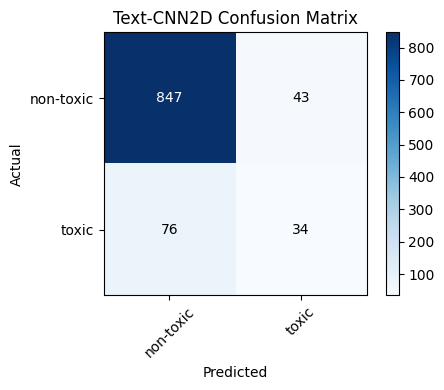

In [ ]:
eval_and_report_softmax(cnn2d, X_test_cnn, Y_test, 'Text-CNN2D')


--- Bi-GRU on Test ---
Accuracy       : 0.8750
Precision-Macro: 0.6744
Recall-Macro   : 0.6589
F1-Micro       : 0.8750
F1-Macro       : 0.6661

              precision    recall  f1-score   support

           0     0.9245    0.9360    0.9302       890
           1     0.4242    0.3818    0.4019       110

    accuracy                         0.8750      1000
   macro avg     0.6744    0.6589    0.6661      1000
weighted avg     0.8695    0.8750    0.8721      1000



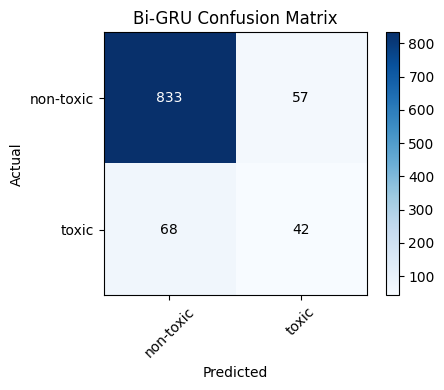

In [ ]:
eval_and_report_softmax(gru2c, X_test_gru, Y_test, 'Bi-GRU')